In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('merged_olympics_data.csv')
df.columns = df.columns.str.strip().str.upper()
df.head()

,YEAR,NOC,SPORT,EVENT,MEDAL,GOLD,SILVER,BRONZE,TOTAL,HOST,DISCIPLINE,CODE,SPORTS GOVERNING BODY,COUNT
0,1992,CHN,basketball,Basketball Men's Basketball,No medal,16,22,16,54,ESP,3x3,BK3,FIBA,0.0
1,1992,CHN,basketball,Basketball Men's Basketball,No medal,16,22,16,54,ESP,Basketball,BKB,FIBA,2.0
2,2012,CHN,judo,Judo Men's Extra-Lightweight,No medal,39,31,22,92,GBR,Judo,JUD,IJF,14.0
3,1920,DEN,football,Football Men's Football,No medal,0,0,0,0,BEL,Football,FBL,FIFA,1.0
4,1900,DEN,tug-of-war,Tug-Of-War Men's Tug-Of-War,Gold,0,0,0,0,FRA,NaN,NaN,NaN,NaN


In [4]:
df['GOLD'] = (df['MEDAL'] == 'Gold').astype(int)
df['SILVER'] = (df['MEDAL'] == 'Silver').astype(int)
df['BRONZE'] = (df['MEDAL'] == 'Bronze').astype(int)
df['TOTAL'] = df['GOLD'] + df['SILVER'] + df['BRONZE']
df['EVENT'] = df['EVENT'].str.strip()
df.head()

,YEAR,NOC,SPORT,EVENT,MEDAL,GOLD,SILVER,BRONZE,TOTAL,HOST,DISCIPLINE,CODE,SPORTS GOVERNING BODY,COUNT
0,1992,CHN,basketball,Basketball Men's Basketball,No medal,0,0,0,0,ESP,3x3,BK3,FIBA,0.0
1,1992,CHN,basketball,Basketball Men's Basketball,No medal,0,0,0,0,ESP,Basketball,BKB,FIBA,2.0
2,2012,CHN,judo,Judo Men's Extra-Lightweight,No medal,0,0,0,0,GBR,Judo,JUD,IJF,14.0
3,1920,DEN,football,Football Men's Football,No medal,0,0,0,0,BEL,Football,FBL,FIFA,1.0
4,1900,DEN,tug-of-war,Tug-Of-War Men's Tug-Of-War,Gold,1,0,0,1,FRA,NaN,NaN,NaN,NaN


In [7]:
# 计算奖牌比例：
country_event_summary = df.groupby(['NOC', 'EVENT']).agg({
    'GOLD': 'sum',
    'SILVER': 'sum',
    'BRONZE': 'sum',
    'TOTAL': 'sum'
}).reset_index()
country_event_summary['GOLD_RATIO'] = country_event_summary['GOLD'] / country_event_summary['TOTAL']
country_event_summary['SILVER_RATIO'] = country_event_summary['SILVER'] / country_event_summary['TOTAL']
country_event_summary['BRONZE_RATIO'] = country_event_summary['BRONZE'] / country_event_summary['TOTAL']
country_event_summary= country_event_summary.fillna(0)
country_event_summary.head()

,NOC,EVENT,GOLD,SILVER,BRONZE,TOTAL,GOLD_RATIO,SILVER_RATIO,BRONZE_RATIO
0,AFG,10m Air Rifle Men,0,0,0,0,0.0,0.0,0.0
1,AFG,Athletics Men's 100 metres,0,0,0,0,0.0,0.0,0.0
2,AFG,Athletics Men's 110 metres Hurdles,0,0,0,0,0.0,0.0,0.0
3,AFG,Athletics Men's 200 metres,0,0,0,0,0.0,0.0,0.0
4,AFG,Athletics Men's 4 x 100 metres Relay,0,0,0,0,0.0,0.0,0.0


In [8]:
# 加权计算奖牌的“重要性得分”：
country_event_summary['GOLD_SCORE'] = country_event_summary['GOLD'] * country_event_summary['GOLD_RATIO']
country_event_summary['SILVER_SCORE'] = country_event_summary['SILVER'] * country_event_summary['SILVER_RATIO']
country_event_summary['BRONZE_SCORE'] = country_event_summary['BRONZE'] * country_event_summary['BRONZE_RATIO']
country_event_summary= country_event_summary.fillna(0)
country_event_summary.head()

,NOC,EVENT,GOLD,SILVER,BRONZE,TOTAL,GOLD_RATIO,SILVER_RATIO,BRONZE_RATIO,GOLD_SCORE,SILVER_SCORE,BRONZE_SCORE
0,AFG,10m Air Rifle Men,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,AFG,Athletics Men's 100 metres,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,AFG,Athletics Men's 110 metres Hurdles,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,AFG,Athletics Men's 200 metres,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,AFG,Athletics Men's 4 x 100 metres Relay,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# 获取每个国家最重要的3个赛事
top_events_by_country = []

for country in country_event_summary['NOC'].unique():
    country_data = country_event_summary[country_event_summary['NOC'] == country]

    # 对 [GOLD_SCORE, SILVER_SCORE, BRONZE_SCORE] 按行求和后排序
    sorted_events = country_data[['GOLD_SCORE', 'SILVER_SCORE', 'BRONZE_SCORE']] \
        .sum(axis=1) \
        .sort_values(ascending=False) \
        .head(3)

    top_3_indices = sorted_events.index

    event_names = country_data.loc[top_3_indices, 'EVENT'].tolist()

    top_events_by_country.append({
        'NOC': country,
        'Top 3 Events': event_names,
        'Total Importance Score': sorted_events.sum()
    })


In [10]:
top_events_df = pd.DataFrame(top_events_by_country)
print(top_events_df)

     NOC                                       Top 3 Events  \
0    AFG  [Taekwondo Men's Featherweight, Taekwondo Men'...   
1    AHO  [Sailing Mixed Windsurfer, Athletics Men's 100...   
2    AIN        [Men's Single Sculls, Women's Doubles, Men]   
3    ALB  [Men's Freestyle 74kg, Men's Freestyle 65kg, 1...   
4    ALG  [Athletics Women's 1,500 metres, Boxing Men's ...   
..   ...                                                ...   
229  YEM   Air Pistol Women, Judo Men's Lightweight,...   
230  YMD  [Athletics Men's 100 metres, Athletics Men's 2...   
231  YUG  [Basketball Men's Basketball, Handball Men's H...   
232  ZAM  [Athletics Men's 400 metres Hurdles, Boxing Me...   
233  ZIM  [Hockey Women's Hockey, Swimming Women's 100 m...   

     Total Importance Score  
0                  2.000000  
1                  1.000000  
2                  5.000000  
3                  4.000000  
4                  5.666667  
..                      ...  
229                0.000000  
230    

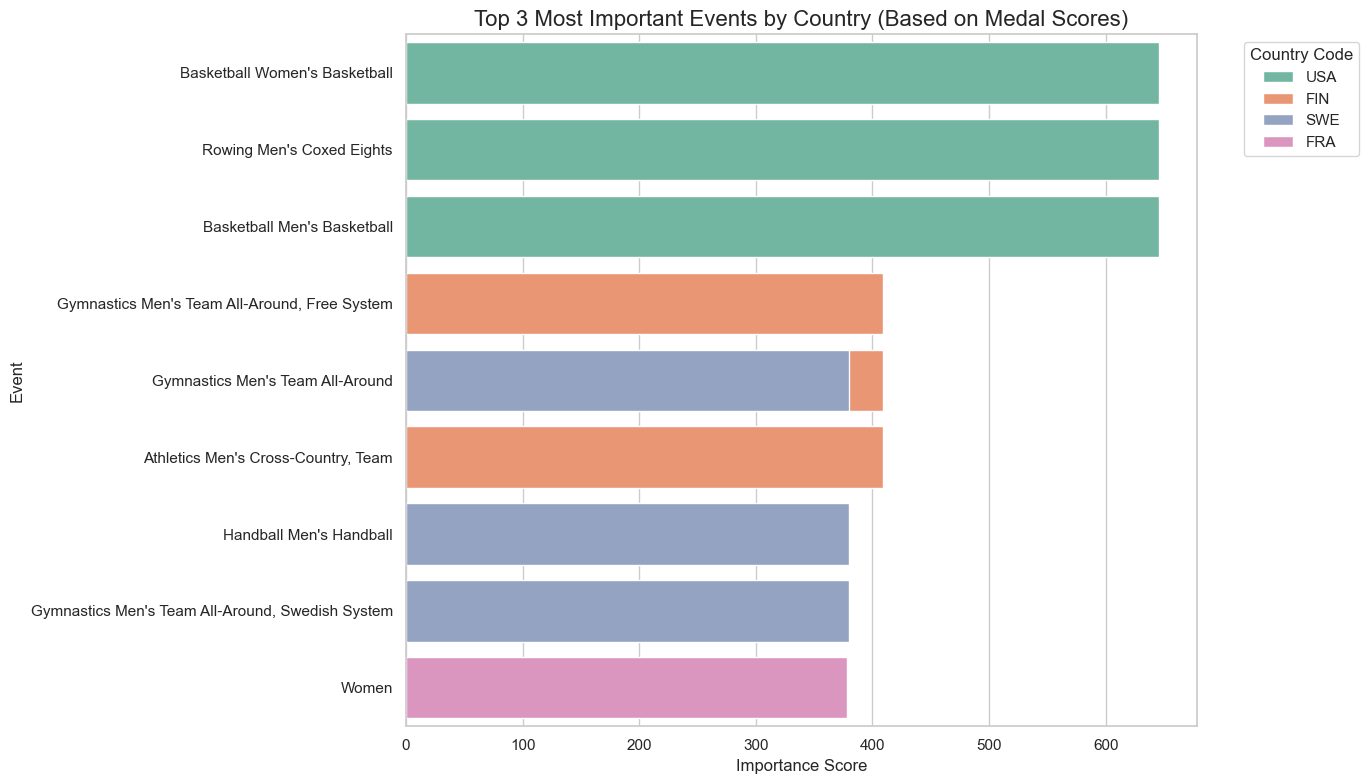

In [16]:
sns.set(style="whitegrid")

# 1. 展示每个国家的前3个赛事及其总得分
# 拆分 Top 3 Events 列，使每个事件成为一行
top_events_df_exploded = top_events_df.explode('Top 3 Events')

# 创建新的列来存储每个事件的得分
top_events_df_exploded['Score'] = top_events_df_exploded['Total Importance Score']

# 2. 按得分排序，限制展示前10个得分最高的赛事
top_events_exploded_sorted = top_events_df_exploded.sort_values(by='Score', ascending=False).head(10)

# 绘制条形图，按总得分排序
plt.figure(figsize=(14, 8))
sns.barplot(x='Score', y='Top 3 Events', hue='NOC', data=top_events_exploded_sorted, dodge=False, palette='Set2')

plt.title('Top 3 Most Important Events by Country (Based on Medal Scores)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Event', fontsize=12)
plt.legend(title='Country Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

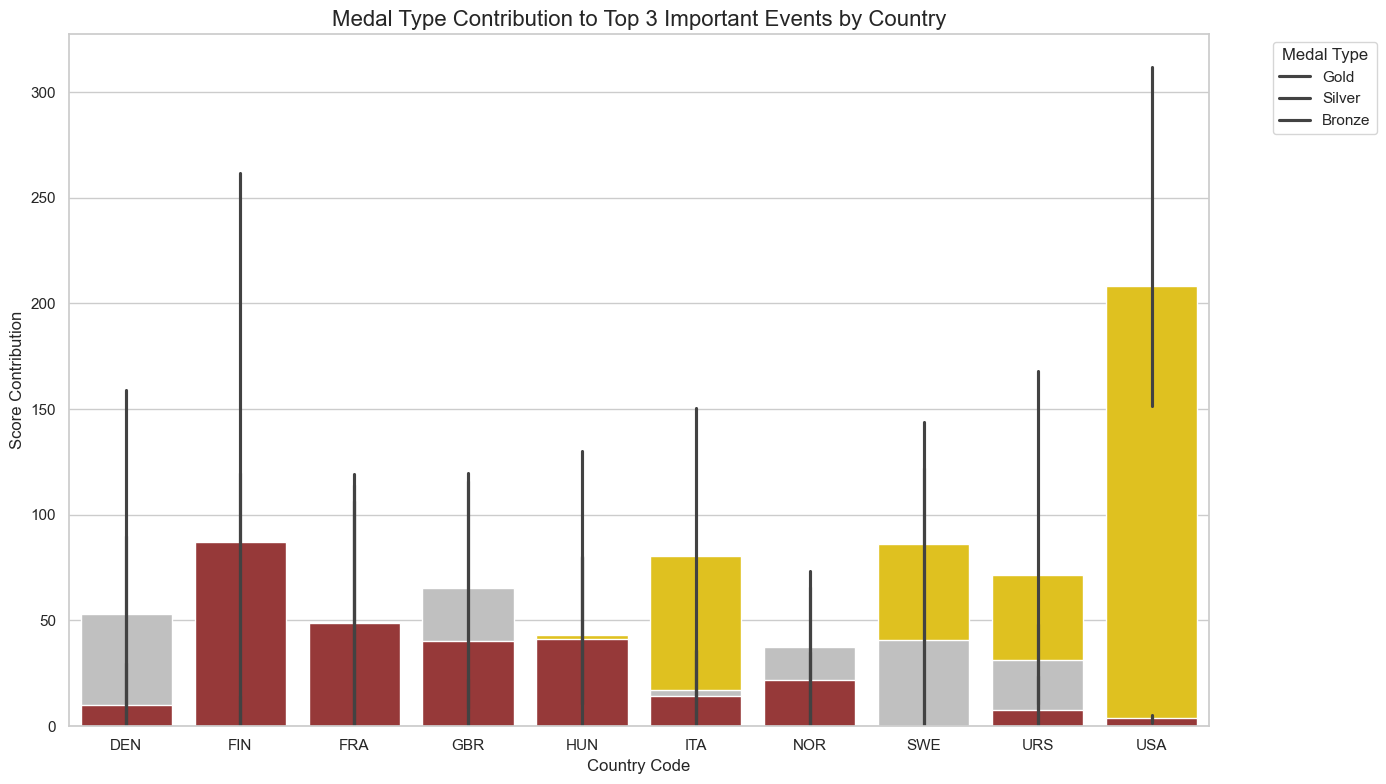

In [18]:
# 为每个国家和事件计算金、银、铜的得分贡献
top_events_df_exploded = top_events_df.explode('Top 3 Events')

# 获取每个事件对应的得分
top_events_df_exploded['Gold Score'] = top_events_df_exploded.apply(
    lambda x: country_event_summary[
        (country_event_summary['NOC'] == x['NOC']) & (country_event_summary['EVENT'] == x['Top 3 Events'])]['GOLD_SCORE'].values[0], 
    axis=1)

top_events_df_exploded['Silver Score'] = top_events_df_exploded.apply(
    lambda x: country_event_summary[
        (country_event_summary['NOC'] == x['NOC']) & (country_event_summary['EVENT'] == x['Top 3 Events'])]['SILVER_SCORE'].values[0], 
    axis=1)

top_events_df_exploded['Bronze Score'] = top_events_df_exploded.apply(
    lambda x: country_event_summary[
        (country_event_summary['NOC'] == x['NOC']) & (country_event_summary['EVENT'] == x['Top 3 Events'])]['BRONZE_SCORE'].values[0], 
    axis=1)

# 计算每个国家的总得分（在Top 3事件中的金、银、铜得分的总和）
top_events_df_exploded['Total Score'] = top_events_df_exploded['Gold Score'] + top_events_df_exploded['Silver Score'] + top_events_df_exploded['Bronze Score']

# 获取总得分排名前 10 的国家
top_10_countries = top_events_df_exploded.groupby('NOC')['Total Score'].sum().nlargest(10).index

# 筛选出前 10 的国家数据
top_10_events_df = top_events_df_exploded[top_events_df_exploded['NOC'].isin(top_10_countries)]

# 绘制堆叠条形图
plt.figure(figsize=(14, 8))
sns.barplot(x='NOC', y='Gold Score', data=top_10_events_df, color='gold', label='Gold', dodge=False)
sns.barplot(x='NOC', y='Silver Score', data=top_10_events_df, color='silver', label='Silver', dodge=False)
sns.barplot(x='NOC', y='Bronze Score', data=top_10_events_df, color='brown', label='Bronze', dodge=False)

plt.title('Medal Type Contribution to Top 3 Important Events by Country', fontsize=16)
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('Score Contribution', fontsize=12)
plt.legend(title='Medal Type', labels=['Gold', 'Silver', 'Bronze'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
